## Train and save your model

Model to predict churn in a bank: https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

### Imports

In [1]:
import dagshub
import mlflow
import itertools
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import  classification_report, accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from matplotlib import rc, rcParams
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);


### Set MLFlow in Dagshub

In [27]:
def get_experiment_id(name):
    exp = mlflow.get_experiment_by_name(name)
    if exp is None:
      exp_id = mlflow.create_experiment(name)
      return exp_id
    return exp.experiment_id


In [26]:
login_dagshub = "ana.oliveira"
repository_name = "MLOPS-Challenge"
dagshub.init(repository_name, login_dagshub, mlflow=True)
mlflow.set_tracking_uri(f"https://dagshub.com/{login_dagshub}/{repository_name}.mlflow")

Initialized MLflow to track repo "ana.oliveira/MLOPS-Challenge"

Repository ana.oliveira/MLOPS-Challenge initialized!

### Load dataset

In [3]:
df = pd.read_csv("data/churn.csv", index_col=0)

### Preprocess data

In [4]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure
    
    if number_of_products == 0:
        return 0
    
    if tenure == 0:
        return number_of_products
    
    rate = number_of_products / tenure
    return rate

In [5]:
def credit_score_table(row):
    
    credit_score = row.CreditScore
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 851:
        return "Top"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score < 300:
        return "Deep"

In [6]:
def countries_monthly_average_salaries(row):
    fr = 3696    
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography              # Germany, France and Spain
    
    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain": 
        return salary / sp

In [7]:
def feature_engineering(df):
    df_fe = df.copy()
    
    # balance_salary_rate
    balance_salary_rate = 'balance_salary_rate'
    df_fe[balance_salary_rate] = df_fe.Balance / df_fe.EstimatedSalary
    
    # product_utilization_rate_by_year
    df_fe = df_fe.assign(product_utilization_rate_by_year=df_fe.apply(lambda x: product_utilization_rate_by_year(x), axis=1)) 
        
    # tenure_rate_by_age - standardize and ratio by customer age, excluding adolescent period!
    tenure_rate_by_age = 'tenure_rate_by_age'
    df_fe[tenure_rate_by_age] = df_fe.Tenure / (df_fe.Age - 17)
    
    # credit_score_rate_by_age - standardize and ratio by age, excluding adolescent period!
    credit_score_rate_by_age = 'credit_score_rate_by_age'
    df_fe[credit_score_rate_by_age] = df_fe.CreditScore / (df_fe.Age - 17)
   
    # credit_score_rate_by_salary - ratio by salary
    credit_score_rate_by_salary = 'credit_score_rate_by_salary'
    df_fe[credit_score_rate_by_salary] = df_fe.CreditScore / (df_fe.EstimatedSalary)
    
    # feature engineering add - credit_score_table
    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))
    
    # feature engineering add - countries monthly average salaries
    df_fe = df_fe.assign(countries_monthly_average_salaries = df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1)) 
    
    return df_fe


In [8]:
def data_encoding(df):
    df_model = df.copy()

    # >>>> Categorical columns <<<<<
    non_encoding_columns = ["Geography","HasCrCard","IsActiveMember","Gender","NumOfProducts","Tenure","credit_score_table"]
    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns,axis=1)
    
    df_encoding = df_non_encoding.copy()
    
    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model,df_encoding],axis=1)

    df_model = df_model.drop(["Geography","Gender","CustomerId","Surname","credit_score_table","CreditScore","EstimatedSalary"],axis=1)
    df_model = df_model.reset_index()
    df_model = df_model.drop('index',axis=1)
    
    df_model.loc[df_model.HasCrCard == 0, 'credit_card_situation'] = -1
    df_model.loc[df_model.IsActiveMember == 0, 'is_active_member'] = -1
    
    return df_model


In [9]:
df_fe = feature_engineering(df)
df_fe.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,credit_score_table,countries_monthly_average_salaries
RowNumber,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.500,0.080000,24.760000,0.006108,Fair,2.285103
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,1.000,0.041667,25.333333,0.005402,Fair,4.155316
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.375,0.320000,20.080000,0.004406,Poor,2.568803


In [10]:
df_encoded = data_encoding(df_fe)
df_encoded.drop(['credit_card_situation', 'is_active_member'], axis=1, inplace=True)
df_encoded.head(3)

,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category
0,42,0.00,1,0.000000,0.500,0.080000,24.760000,0.006108,2.285103,1,1,1,2,0,0,1
1,41,83807.86,0,0.744677,1.000,0.041667,25.333333,0.005402,4.155316,0,1,1,1,0,2,1
2,42,159660.80,1,1.401375,0.375,0.320000,20.080000,0.004406,2.568803,1,0,3,8,0,0,3


### Train models

In [11]:
dependent_variable_name = "Exited"

In [12]:
def model_prepare(df_model):
    y = df_model[dependent_variable_name]
    X = df_model.loc[:, df_model.columns != dependent_variable_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)
    
    return X_train, X_test, y_train, y_test

In [34]:
def data_training(X_train, X_test, y_train, y_test, mlflow_tags, experiment_name):
    models = []
    models.append(('LOGR',LogisticRegression()))
    models.append(('KNN',KNeighborsClassifier()))
    models.append(('CART',DecisionTreeClassifier()))
    models.append(('RF',RandomForestClassifier()))
    models.append(('GBM',GradientBoostingClassifier()))
    models.append(('XGBoost',XGBClassifier()))
    models.append(('LightGBM',LGBMClassifier()))
    models.append(('CatBoost',CatBoostClassifier()))

    model_metrics = ["model","accuracy_score","scale_method","0_precision","0_recall","1_precision","1_recall"]
    df_result = pd.DataFrame(columns=model_metrics)

    index = 0
    for name, model in models:
        mlflow.set_experiment(experiment_id = get_experiment_id(experiment_name))
        with mlflow.start_run(nested=True):
            
            # Params
            params = {"model_name": name}
            
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            
            score = accuracy_score(y_test,y_pred)
            class_report = classification_report(y_test,y_pred,digits=2,output_dict=True)
            zero_report = class_report['0']
            one_report = class_report['1']
            
            mlflow.set_tags(mlflow_tags)
            mlflow.set_tag("Model", name)
            mlflow.log_params(params)
            mlflow.log_metric("accuracy", score)
            mlflow.log_metric("0_precision", zero_report['precision'])
            mlflow.log_metric("0_recall", zero_report['recall'])
            mlflow.log_metric("1_precision", one_report['precision'])
            mlflow.log_metric("1_recall", one_report['recall'])
            
            df_result.loc[index, model_metrics] = [name, score, "NA", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
            index += 1
            
            mlflow.end_run()
        
    return df_result.sort_values("accuracy_score", ascending=False)


In [31]:
X_train, X_test, y_train, y_test = model_prepare(df_model = df_encoded)

In [32]:
# Set experiment in MLFlow
experiment_name = 'MLOPS-challenge'

# TAGS
user = 'ana.oliveira'
model = 'LGBM'
test_description = 'First Log test' # Qualquer obs pertinente
test_family = 'choose_model'

# Tags para organizar os experimentos
tags = {
        "experiment_name": experiment_name,
        "user": user,
        "test_family": test_family,
        "test_description": test_description
}

In [35]:
training_result = data_training(X_train, X_test, y_train, y_test, tags, experiment_name)
display(training_result)

[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205500 -> initscore=-1.352267
[LightGBM] [Info] Start training from score -1.352267
Learning rate set to 0.025035
0:	learn: 0.6723829	total: 161ms	remaining: 2m 40s
1:	learn: 0.6527655	total: 165ms	remaining: 1m 22s
2:	learn: 0.6344181	total: 169ms	remaining: 56.2s
3:	learn: 0.6178442	total: 173ms	remaining: 43.2s
4:	learn: 0.6035378	total: 176ms	remaining: 35.1s
5:	learn: 0.5890416	total: 179ms	remaining: 29.7s
6:	learn: 0.5748558	total: 184ms	remaining: 26.1s
7:	learn: 0.5614719	total: 187ms	remaining: 23.2s
8:	learn: 0.5

,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
7,CatBoost,0.867,NA,0.88601,0.957685,0.741445,0.496183
3,RF,0.866,NA,0.87975,0.965152,0.763713,0.46056
4,GBM,0.862,NA,0.87791,0.962041,0.74477,0.452926
6,LightGBM,0.8615,NA,0.884393,0.952085,0.714815,0.491094
5,XGBoost,0.856,NA,0.882319,0.947106,0.690909,0.483461
1,KNN,0.8305,NA,0.866051,0.933416,0.600746,0.409669
0,LOGR,0.814,NA,0.828632,0.968886,0.586777,0.180662
2,CART,0.7965,NA,0.873599,0.873055,0.482234,0.483461


### Model fine-tuning

In [36]:
# Function to give best model score and parameters

def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


LGBM Model Tuning

In [37]:
# Set experiment in MLFlow
experiment_name = 'MLOPS-challenge'

# TAGS
user = 'ana.oliveira'
model = 'LGBM'
test_description = 'First Log test' # Qualquer obs pertinente
test_family = 'finetuning'

# Tags para organizar os experimentos
tags = {
        "experiment_name": experiment_name,
        "user": user,
        "Model": model,
        "test_family": test_family,
        "test_description": test_description
}

In [38]:
params = {
    'model_name': model,
    'silent': 0,
    'learning_rate': 0.09,
    'max_delta_step': 2,
    'n_estimators': 100,
    'boosting_type': 'gbdt',
    'max_depth': 10,
    'eval_metric': 'logloss',
    'gamma': 3,
    'base_score': 0.5
}

In [39]:
mlflow.set_experiment(experiment_id = get_experiment_id(experiment_name))
with mlflow.start_run(nested=True):

    lgbm_model = LGBMClassifier(**params)
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.set_tags(tags)
    mlflow.log_params(params)
    mlflow.log_metric("accuracy", accuracy)
    
    print(classification_report(y_test, y_pred, digits=2))
    print("Accuracy score of tuned LightGBM model: ", accuracy)

[LightGBM] [Warning] Unknown parameter: model_name
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: model_name
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

Confusion Matrix

Confusion matrix, without normalization
[[1537   70]
 [ 206  187]]
True Negatives:  1537
False Positives:  70
False Negatives:  206
True Positives:  187


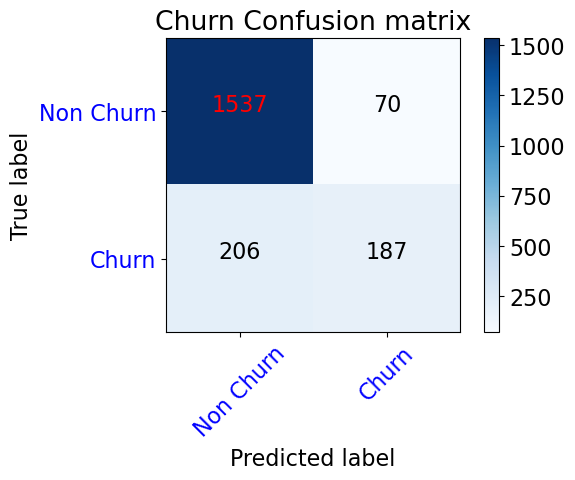

In [40]:
cfm = confusion_matrix(y_test, y_pred=y_pred)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Churn Confusion matrix')


tn, fp, fn, tp = cfm.ravel()
print("True Negatives: ", tn)
print("False Positives: ", fp)
print("False Negatives: ", fn)
print("True Positives: ", tp)

ROC Curve

[LightGBM] [Warning] Unknown parameter: model_name
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


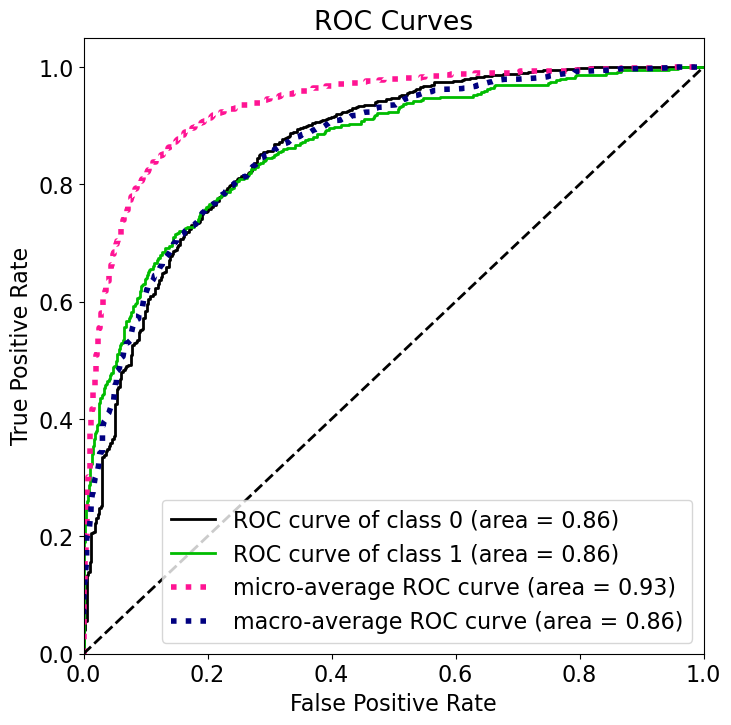

In [41]:
y_pred_proba = lgbm_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8,8))

plt.show()

### Save model

In [42]:
import pickle
with open('lgbm_model.pkl', 'wb') as model_file:
    pickle.dump(lgbm_model, model_file)